In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import mean_squared_error
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Read in the data (this section should be the same for everyone)
url = "https://api.github.com/repos/stevedemirev/CFRM521-ProjectData/contents/filtered"
response = requests.get(url)
files = response.json()

csv_files = sorted([file for file in files if file['name'].endswith('.csv')], key = lambda x: x['name'])

def get_datasets(files):
    df = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file['download_url'])
        df = pd.concat([df, temp], ignore_index = True)
    return df

full_df = get_datasets(csv_files)
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
# Filter to Calls Only
full_df = full_df[full_df['type'] == "call"]
# Filter to every 10th row
full_df = full_df.iloc[::10]

total_files = len(full_df)
train_size = int(total_files*0.7)
val_size = int(total_files*0.85)

train = full_df[:train_size]
valid = full_df[train_size:val_size]
test = full_df[val_size:]

In [3]:

def define_features(df):
    df['expiration'] = pd.to_datetime(df['expiration'])
    df['quote_date'] = pd.to_datetime(df['quote_date'])
    df['tte'] = (df['expiration'] - df['quote_date']).dt.days / 252
    X = df[['close', 'strike', 'delta', 'gamma',
            'vega', 'theta', 'implied_volatility', 'tte']]
    y = df['mid_price']
    return X, y

def get_features():
    X_feats = []
    y_feats = []
    for df in [train, valid, test]:
        df = df.copy()
        X, y = define_features(df)
        X_feats.append(X)
        y_feats.append(y)
    return X_feats, y_feats

X_feats, y_feats = get_features()
X_train, X_valid, X_test = X_feats
y_train, y_valid, y_test = y_feats

## Gradient Boost

For my model, I chose Gradient Boosting for it's popularity in machine learning applications and it's relative speed compared to other more intensive models. Gradient boost focuses on fitting new predictors to residual errors made by the previous iteration, making it ideal for predicting the price of options. 

Starting with an initial model, we can generate a basic model with certain inital features, and see how good of a fit we get. We pick the inital features based on prior knowledge of Gradient Boosting regressors, as well as unseen iteration of the model to get a decent fit that runs in decent time. This method is not scientifically sound, but given the scope of the project, is used to better manage storage and time concerns. 

We expect the mean squared and mean absolute error to be better for the final model, but in the meantime, we can see how how the model behaves. 

In [6]:
gbrt = GradientBoostingRegressor(max_depth=5,
                                 n_estimators=120,
                                 learning_rate=0.5,
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)

In [7]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.217154012619384
Mean absolute error of test set: 1.8057905861580072


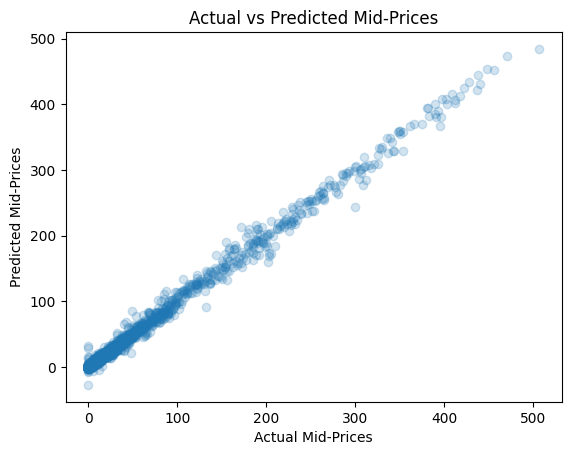

In [8]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

## Hyperparameter search

For hyperparameter tuning, we have a couple parameters that we can adjust for a better fit. 
- **n_estimators** is the number of predictors or trees within the ensemble
- **Learning_rate** scales the effect the previous predictor has in constructing the next predictor
- **n_iter_no_change** Helps prevent overfitting. If the previous *k* predictors have not improved the error, the model is stopped early. If this hyperparameter is too large, the model will overfit nonetheless, and thus needs to be chosen carefully. 

While another method such as GridSearchCV is available for hyperparameter tuning, the more systematic way is to adjust the learning rate, and find a good value of n_estimators that minimizes the error on the validation set. Additionally, gradient boost is prone to overfitting, and this approach will help to prevent such overfitting from occuring. In order to better serve this goal, we will use both the MSE and MAE to find the best model, as the MSE may end up being skewed by outlier error and MAE can provide better insight into the best gradient boosting model. 

We begin by finding the best learning parameter, assuming we fix the all other parameters from the initial model: 

In [11]:
for l in (0.05, 0.1, 0.3, 0.5, 0.7, 1.0):
    gbrt = GradientBoostingRegressor(max_depth=5, 
                                     learning_rate=l,
                                     n_iter_no_change=5,
                                     n_estimators=120, 
                                     random_state=42
    )
    gbrt.fit(X_train, y_train)

    gbrt.staged_predict(X_valid)
    errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
    best_MSE = np.min(errors)
    best_MAE = np.min(errs)
    print()
    print(f'Learning rate: {l}')
    best_n_estimators = np.argmin(errors)+1
    best_n_est = np.argmin(errs)+1
    print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
    print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.05
min MSE: 17.1656, number of trees: 120
min MAE: 1.9258, number of trees: 120

Learning rate: 0.1
min MSE: 9.2520, number of trees: 120
min MAE: 1.4823, number of trees: 120

Learning rate: 0.3
min MSE: 9.3152, number of trees: 120
min MAE: 1.4869, number of trees: 120

Learning rate: 0.5
min MSE: 14.4942, number of trees: 72
min MAE: 1.8786, number of trees: 73

Learning rate: 0.7
min MSE: 24.7325, number of trees: 47
min MAE: 2.3652, number of trees: 47

Learning rate: 1.0
min MSE: 59.3865, number of trees: 36
min MAE: 3.3471, number of trees: 43


Learning rate 0.1 has the smallest MSE and MAE, and as such, is the learning rate that will be used going forward. Now, we fix the learning rate, begin looking for the ideal number of estimators, based on both the MSE, MAE, and the previous learning rate search. We set *n_estimators* equal to 500 to give the model plenty of trees to use.  

In [13]:
gbrt = GradientBoostingRegressor(max_depth=5, 
                                 learning_rate=0.1,
                                 n_estimators=700, 
                                 n_iter_no_change=5,
                                 random_state=42)
gbrt.fit(X_train, y_train)

gbrt.staged_predict(X_valid)



errors = [mean_squared_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
errs = [mean_absolute_error(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid)]
best_MSE = np.min(errors)
best_MAE = np.min(errs)
print()
print('Learning rate: 0.1')
best_n_estimators = np.argmin(errors)+1
best_n_est = np.argmin(errs)+1
print('min MSE: {:.4f}, number of trees: {}'
          .format(best_MSE, best_n_estimators))
print('min MAE: {:.4f}, number of trees: {}'
          .format(best_MAE, best_n_est))


Learning rate: 0.1
min MSE: 4.5570, number of trees: 668
min MAE: 0.9851, number of trees: 669


From here, we have a couple differnt values we can use for the *n_estimator*. can see we have two different values for the number of trees to use in the best model. As such, we can build both models, and compare the MSE and MAE of each to see what produces the best model, and fit other hyperparameters based on this. 

In [15]:
y_pred = []
for param, i in zip([120, 668, 669], range(0, 3)):
    test_model = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.3,
                                           n_estimators=param, 
                                           n_iter_no_change=5,
                                           random_state=42)

    test_model.fit(X_train, y_train)
    pred = test_model.predict(X_test)
    y_pred.append(pred)


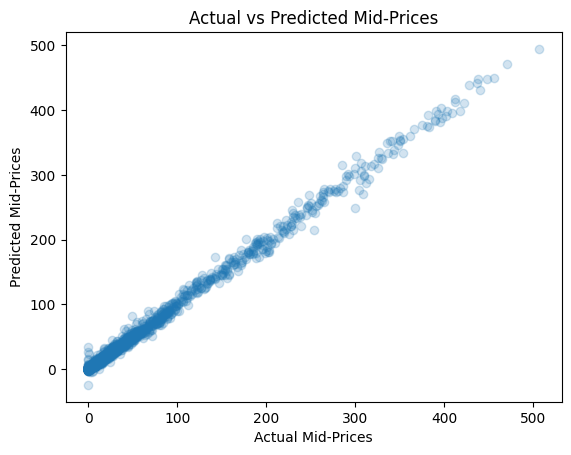

Mean squared error of test set: 10.79153965039579
Mean absolute error of test set: 1.4946342385985543


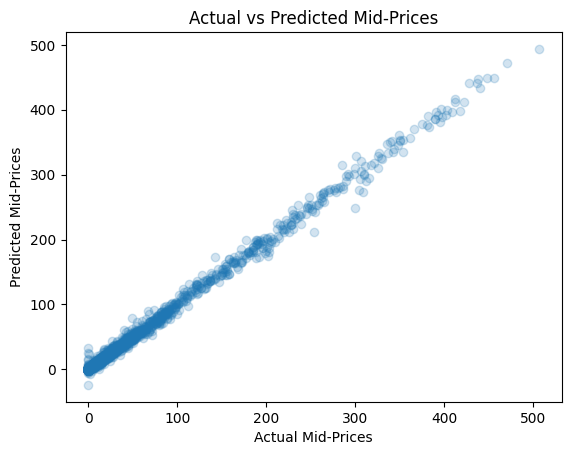

Mean squared error of test set: 9.6815022703375
Mean absolute error of test set: 1.3597225152182335


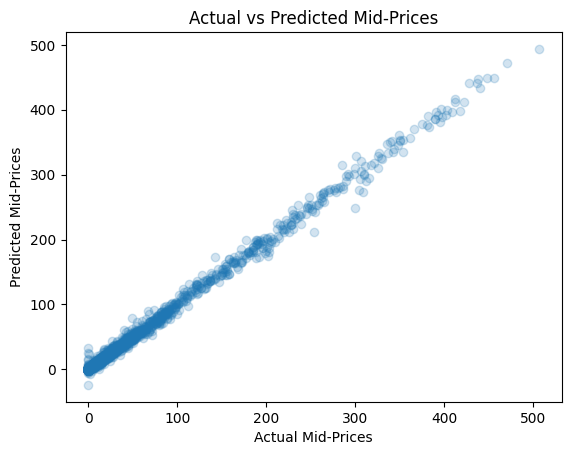

Mean squared error of test set: 9.6815022703375
Mean absolute error of test set: 1.3597225152182335


In [16]:
index = range(0, len(y_test))
for pred in y_pred:
    plt.scatter(y_test, pred, alpha=0.2)
    plt.xlabel("Actual Mid-Prices")
    plt.ylabel("Predicted Mid-Prices")
    plt.title('Actual vs Predicted Mid-Prices')
    plt.show()
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f'Mean squared error of test set: {mse}')
    print(f'Mean absolute error of test set: {mae}')

The visible MSE and MAE for two of the *n_estimators* is visibly identical, and as such, implies that there may be a problem with the parameter *n_iter_o_change*. In conjunction with the small difference in MSE, and especially MAE with 120 *n_estimators* compared to 668 *n_estimators*, this is supported further. 

## Best Model

In [20]:
best_model_mse = GradientBoostingRegressor(max_depth=5, 
                                           learning_rate=0.5,
                                           n_estimators=668, 
                                           n_iter_no_change=5,
                                           random_state=42)
%time best_model_mse.fit(X_train, y_train)

y_pred = best_model_mse.predict(X_test)

CPU times: total: 10.4 s
Wall time: 10.5 s


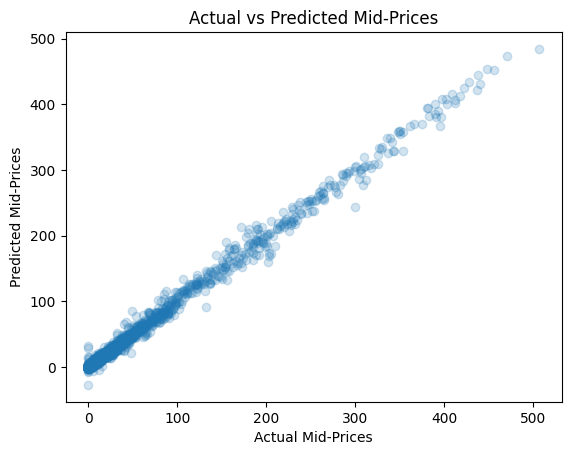

In [21]:
index = range(0, len(y_test))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.xlabel("Actual Mid-Prices")
plt.ylabel("Predicted Mid-Prices")
plt.title('Actual vs Predicted Mid-Prices')
plt.show()

In [22]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error of test set: {mse}')
print(f'Mean absolute error of test set: {mae}')

Mean squared error of test set: 15.217154012619384
Mean absolute error of test set: 1.8057905861580072


Based on the results, I think it's very possible the model is overfitting, especially given the more miniscule changes in the MSE and MAE, and indeed Gradient Boosting has more hyperparameters that could be changed, and more fitting that can be done to provide a better model, beyond what's shown in this report. However, given what's shown, Gradient Boost could potentially make a decent model for option prediction, but more work would be needed to say for certain. However, in comparison to other models, the MSE and MAE are much larger, marking Gradient Boosting as a potentially bad algorithm to use for this kind of application.